# Random Forests

In [1]:
import os
import sys
current_path = os.getcwd()
current_path

'/workspaces/Band-gap-predict/Models/RFR'

In [2]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import model_performance, plot_feature_importance

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
# save the model 
import joblib

In [4]:
# some global variables
RANDOM_SEED = 42

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

In [6]:
dft_train.head()

,composition,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData avg_dev AtomicWeight,...,MagpieData range GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,band_gap
0,Nd4 Ga4 Ge8 O28,87.0,68.0,78.181818,11.520661,87.0,15.999400,144.242000,128.242600,34.160856,...,0.00000,0.000000,0.0,12.0,225.0,213.0,72.000000,77.818182,12.0,3.2096
1,Li4 Mn4 P12 O36,87.0,86.0,77.500000,14.571429,87.0,6.941000,54.938045,47.997045,8.927050,...,0.00031,0.000041,0.0,2.0,229.0,227.0,40.000000,52.285714,12.0,4.3148
2,Ga5 P3 S3,88.0,14.0,80.272727,5.702479,74.0,30.973762,69.723000,38.749238,18.943943,...,0.00000,0.000000,0.0,2.0,70.0,68.0,48.727273,25.487603,64.0,1.3431
3,In4 P2 O10,87.0,12.0,83.500000,4.375000,87.0,15.999400,114.818000,98.818600,36.121077,...,0.00000,0.000000,0.0,2.0,139.0,137.0,42.500000,48.250000,12.0,2.0734
4,K6 Tb6 F30,93.0,90.0,71.000000,31.428571,93.0,18.998403,158.925350,139.926947,33.447420,...,0.00000,0.000000,0.0,15.0,229.0,214.0,71.142857,80.204082,15.0,0.0149


In [7]:
dft_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46514 entries, 0 to 46513
Columns: 108 entries, composition to band_gap
dtypes: float64(107), object(1)
memory usage: 38.3+ MB


In [8]:
dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp__train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp__train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

In [9]:
def model_train(model, X_train, y_train):
    """
    Train and evaluate a Random Forest Regressor.
    """
    # using pipline to scale the data and fit the model
    pipe = Pipeline([
        ('scaler', StandardScaler()), # StandardScaler's mean is 0 and std is 1, Z-score normalization
        ('model', model)
    ], verbose=True)

    # Fit the model
    pipe.fit(X_train, y_train)
    return pipe

def predict(model, X_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    return y_pred

In [10]:
# Predict on the test set
def results(model, X_test, y_test, save_df, train_type='dft', test_type='dft'):
    """
    Predict and evaluate the model on the test set.
    Save the results(model, figures, predictions)
    """
    type = f'{train_type}_train_{test_type}_test'
    y_pred = predict(model, X_test)

    # save the results
    # save fig
    fig_path = os.path.join(current_path, 'figures')
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig_path = os.path.join(fig_path, f'{type}.png')
    r2, rmse, mae = model_performance(y_test, y_pred, fig_path)
    print(f"{type} results:")
    print(f"R^2: {r2:.4f}", f"RMSE: {rmse:.4f}", f"MAE: {mae:.4f}")

    # save the model
    # save the pipeline model(contains scaler and model)
    model_path = os.path.join(current_path, 'model')
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path = os.path.join(model_path, f'{train_type}.pkl')
    joblib.dump(model, model_path)
    # save y_pred
    file_path = os.path.join(current_path, 'predictions')
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    file_path = os.path.join(file_path, f'{type}.csv')
    y_pred_df = save_df.copy()
    y_pred_df['predicted_band_gap'] = y_pred
    y_pred_df.to_csv(file_path, index=False)

    return [r2, rmse, mae]

## Model -- Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=None, max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1)

## DFT Train

In [12]:
# dft train
dft_model = model_train(rf_model, dft_train_X, dft_train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 2.3min


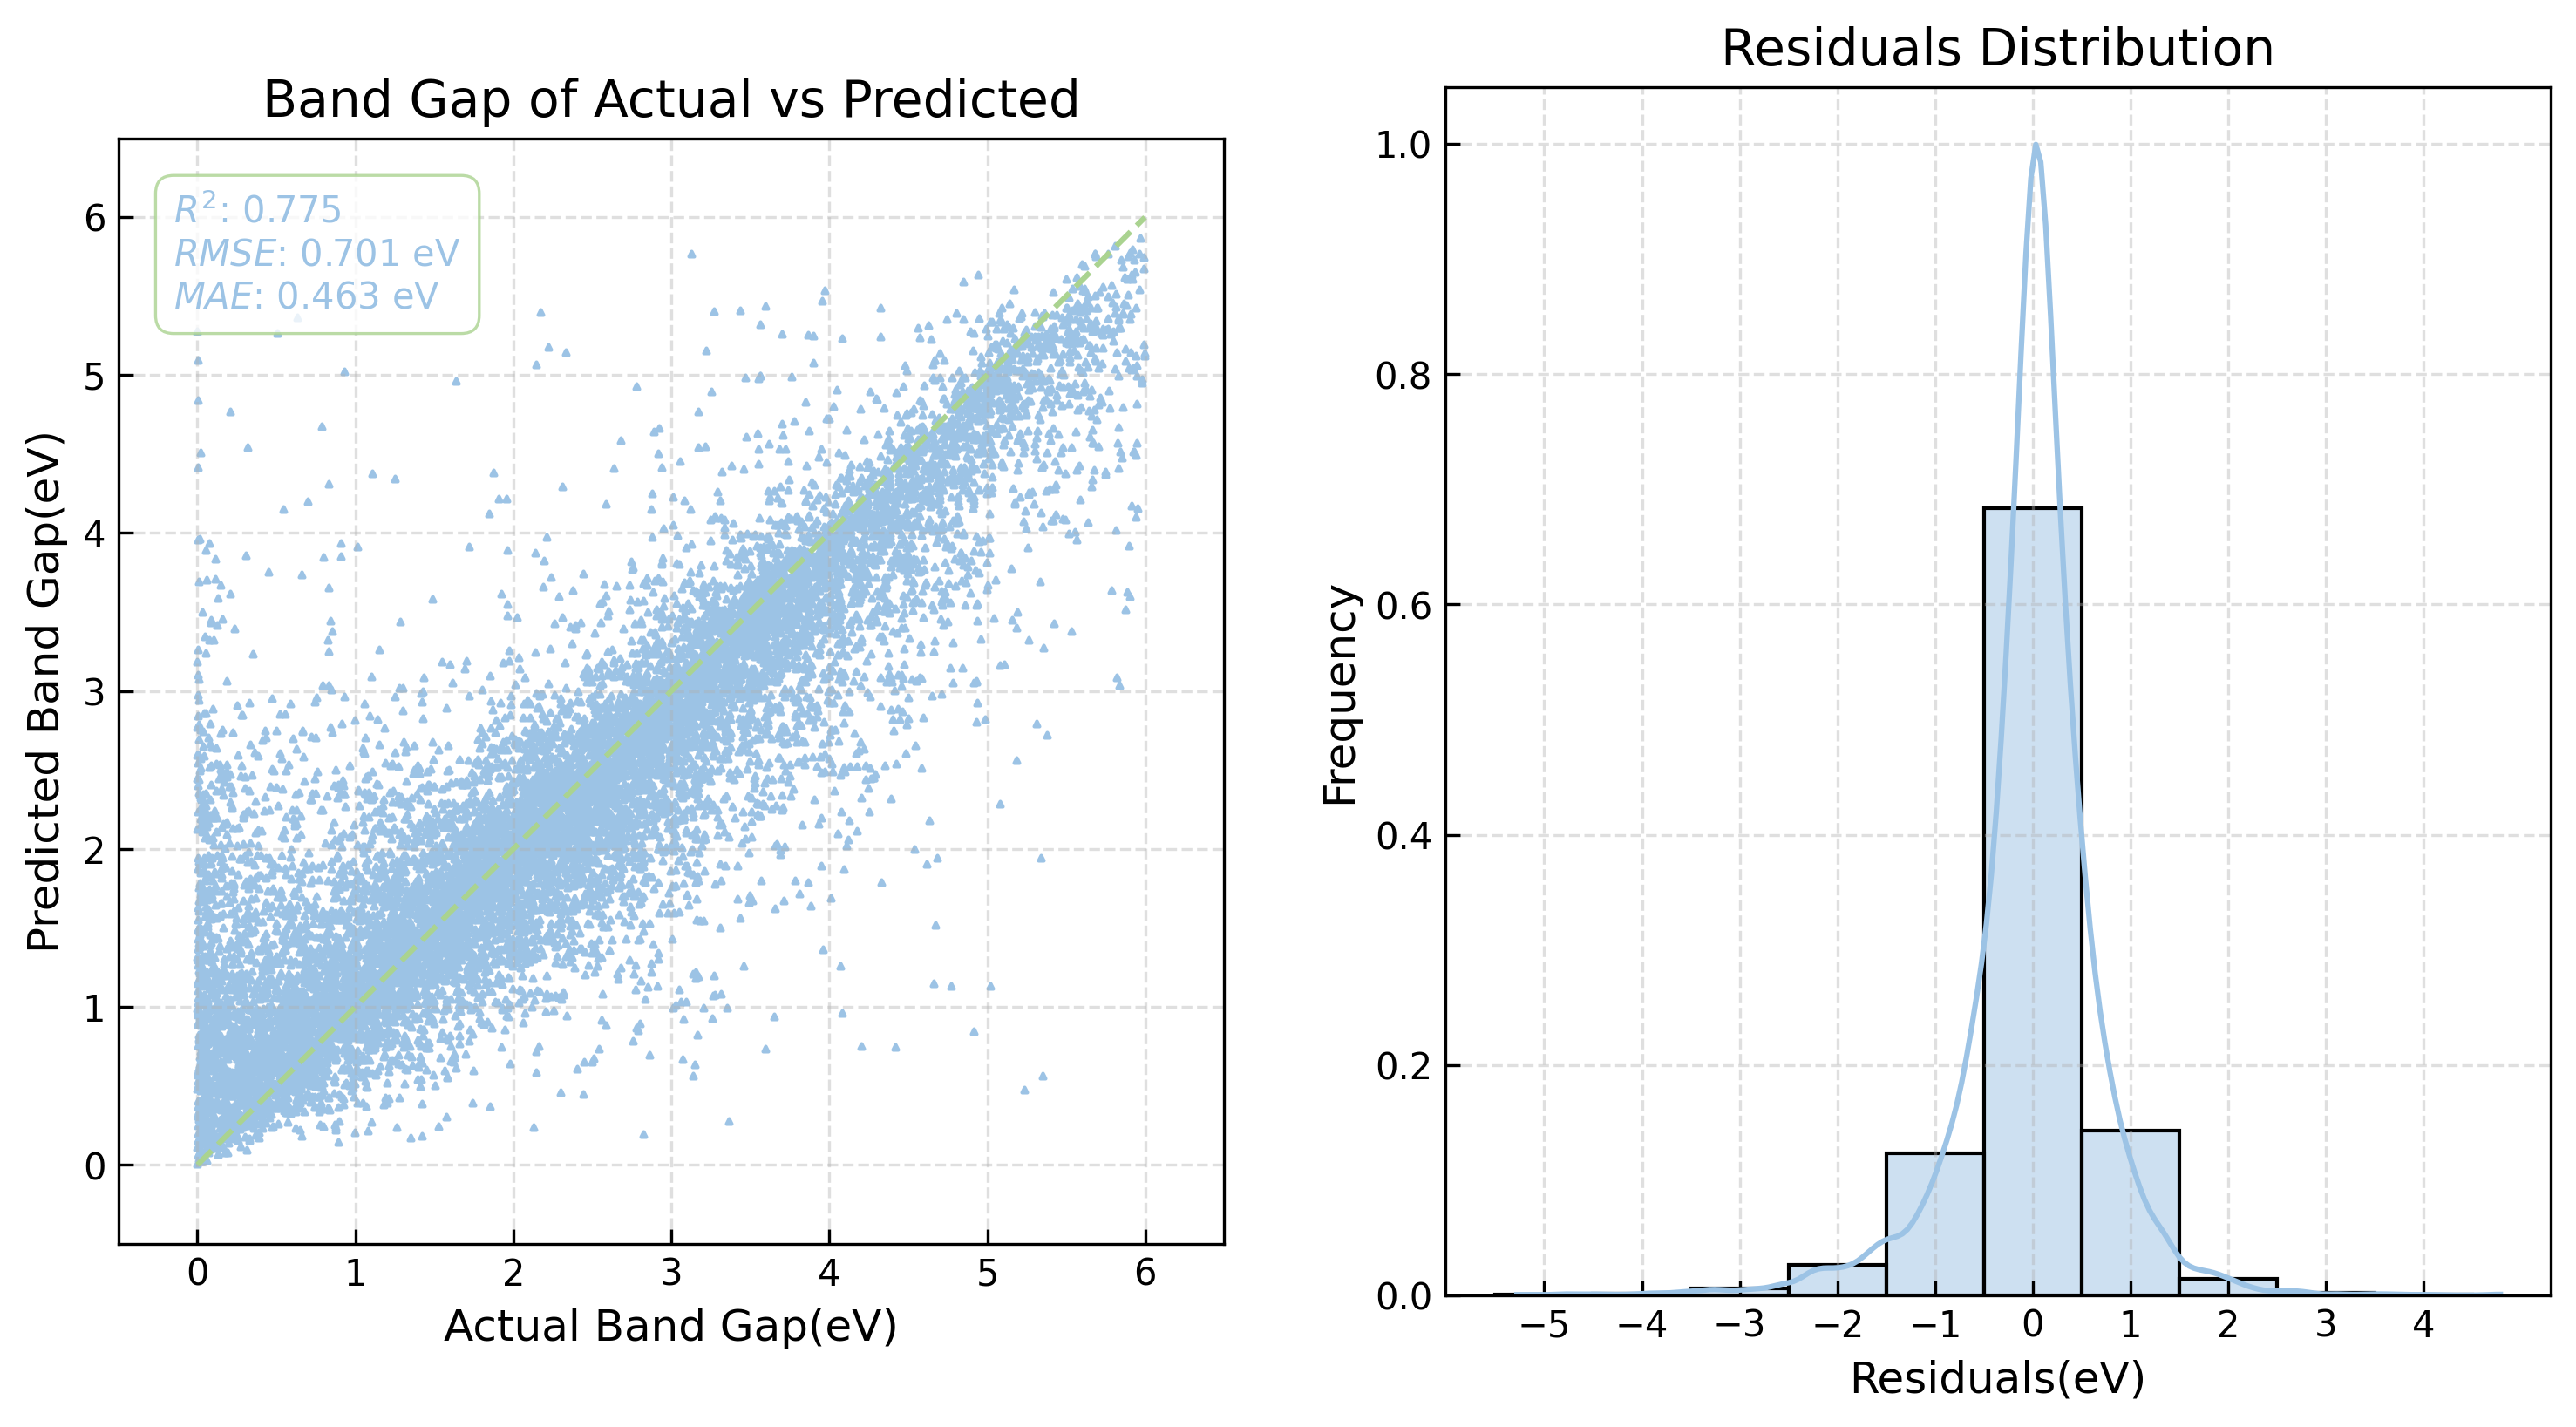

dft_train_dft_test results:
R^2: 0.7749 RMSE: 0.7013 MAE: 0.4632


In [13]:
results_df = pd.DataFrame(columns=['Train', 'Test', 'R^2', 'RMSE', 'MAE'])
# dft test
res1 = results(dft_model, dft_test_X, dft_test_y, dft_test, train_type='dft', test_type='dft')
results_df.loc[len(results_df)] = ['dft', 'dft'] + res1

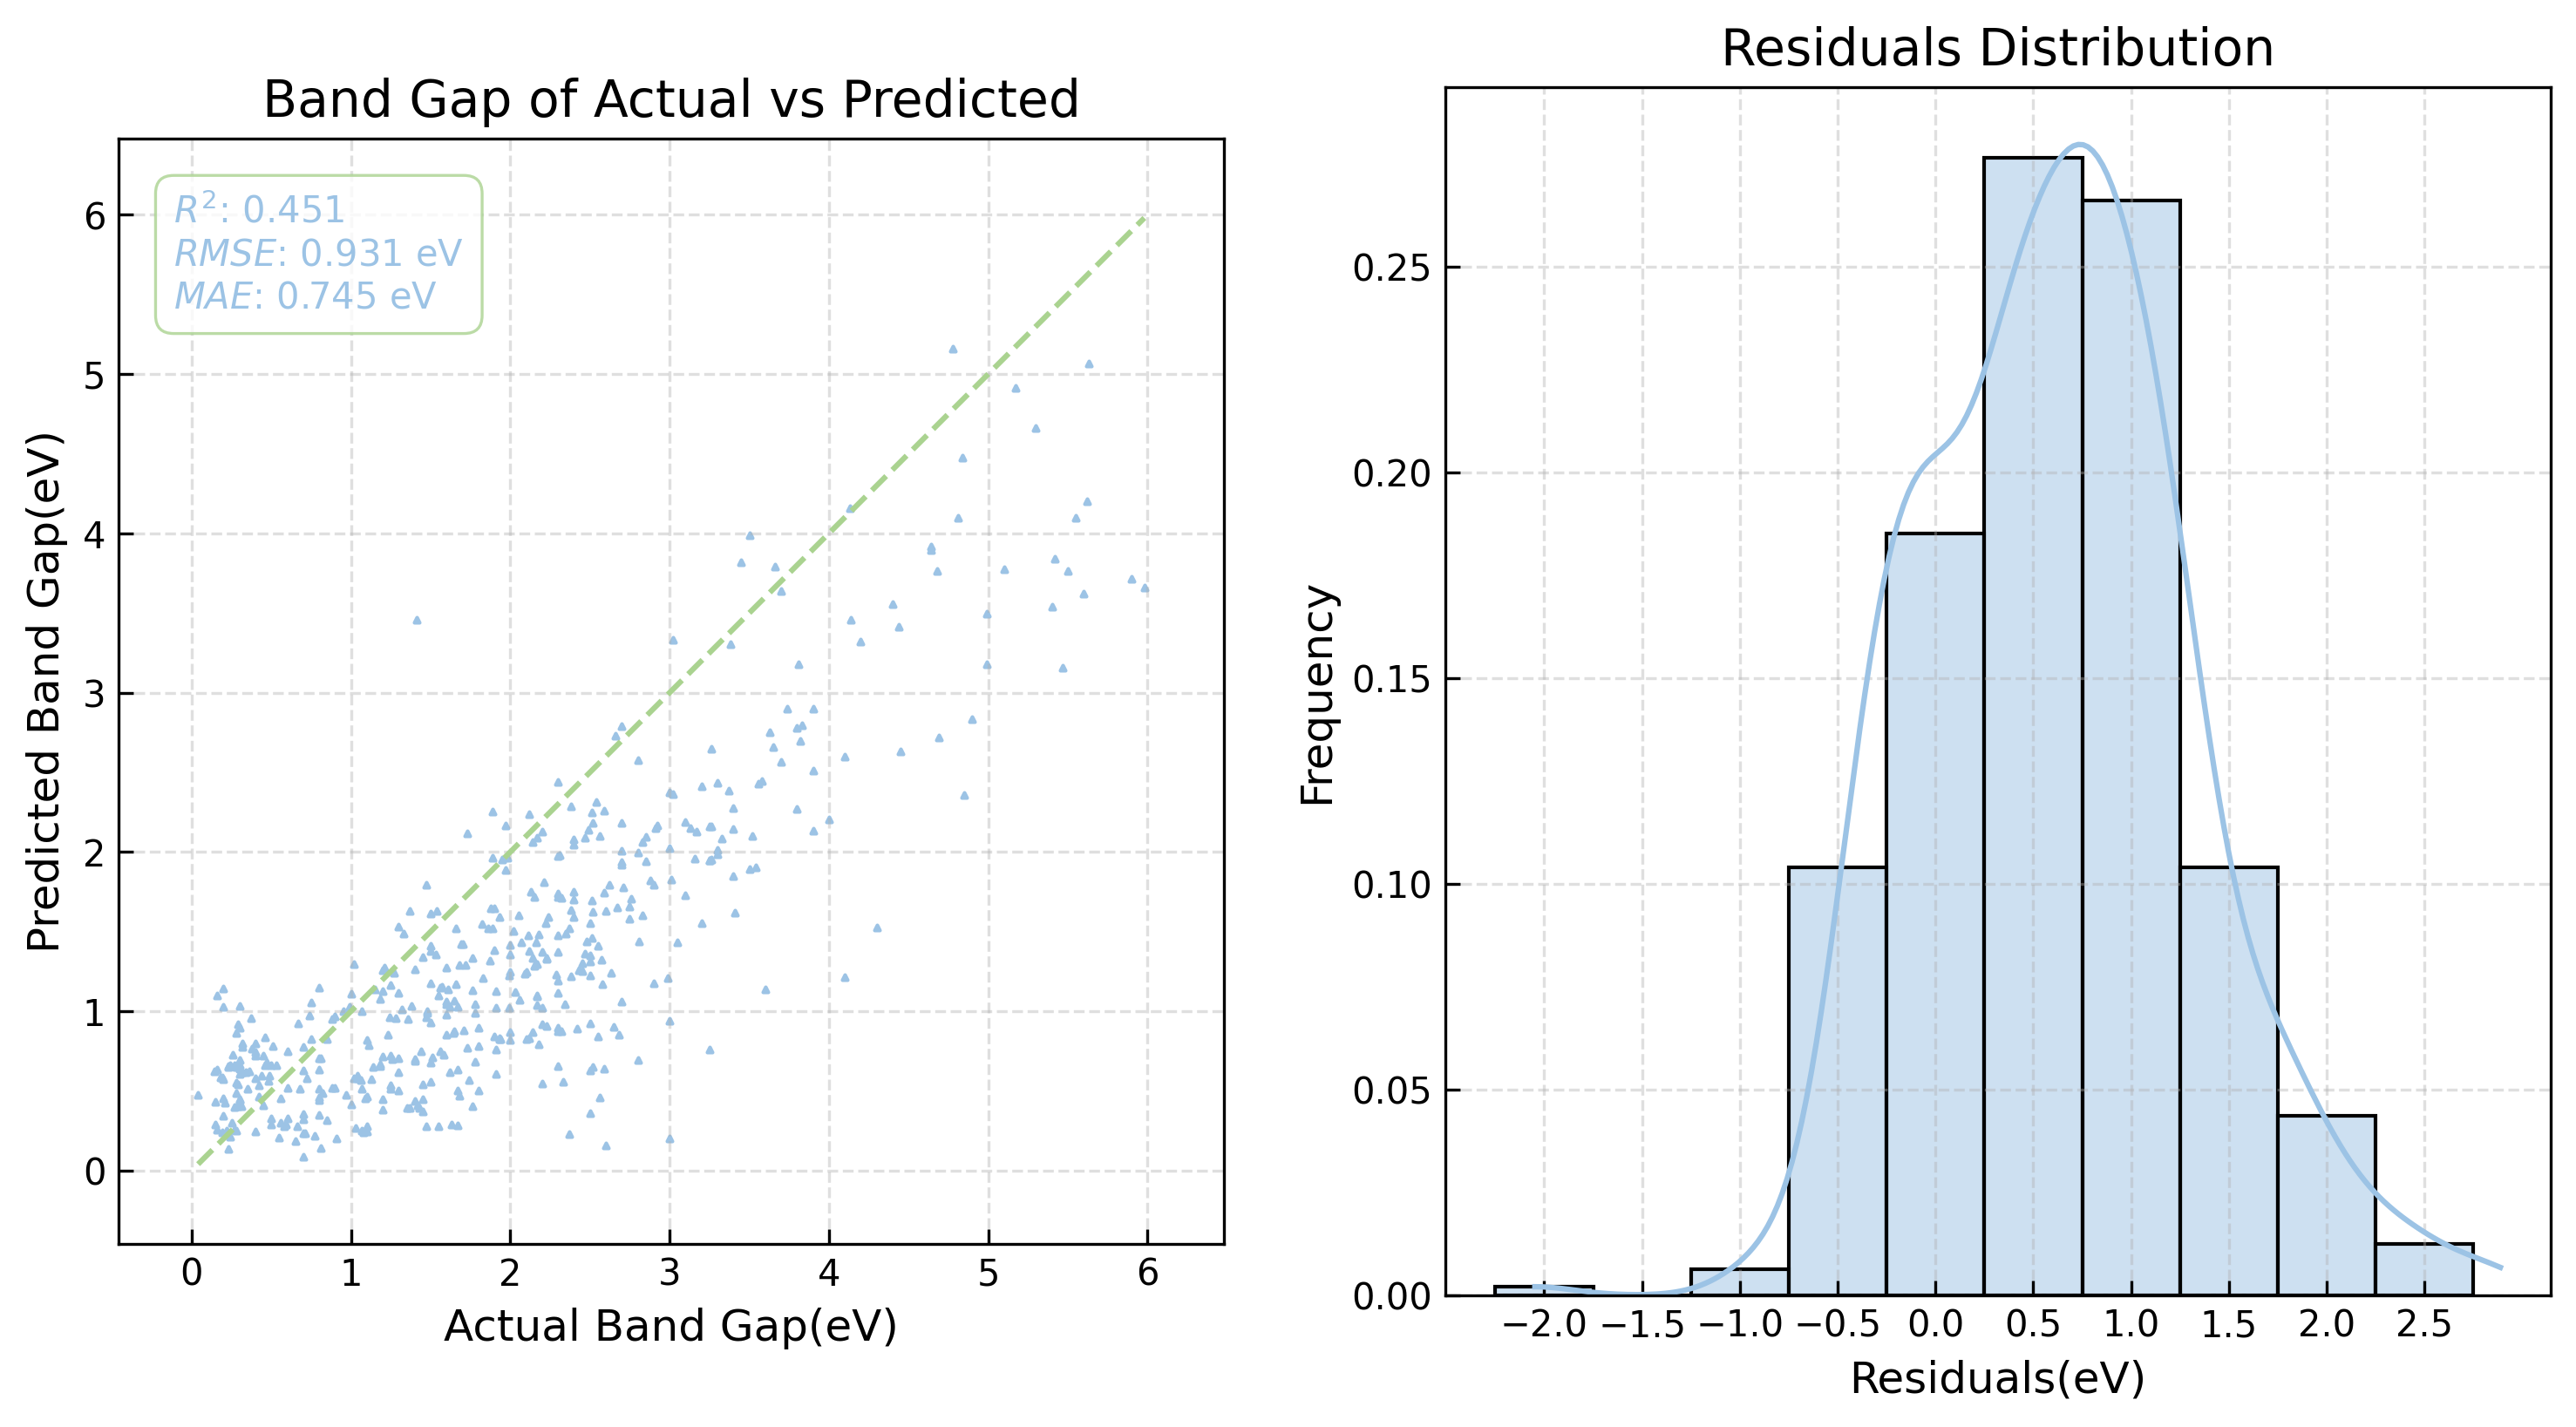

dft_train_exp_test results:
R^2: 0.4510 RMSE: 0.9311 MAE: 0.7452


In [14]:
# Predict on the experimental data
res2 = results(dft_model, exp_test_X, exp_test_y, exp_test, train_type='dft', test_type='exp')
results_df.loc[len(results_df)] = ['dft', 'exp'] + res2

### Features importance

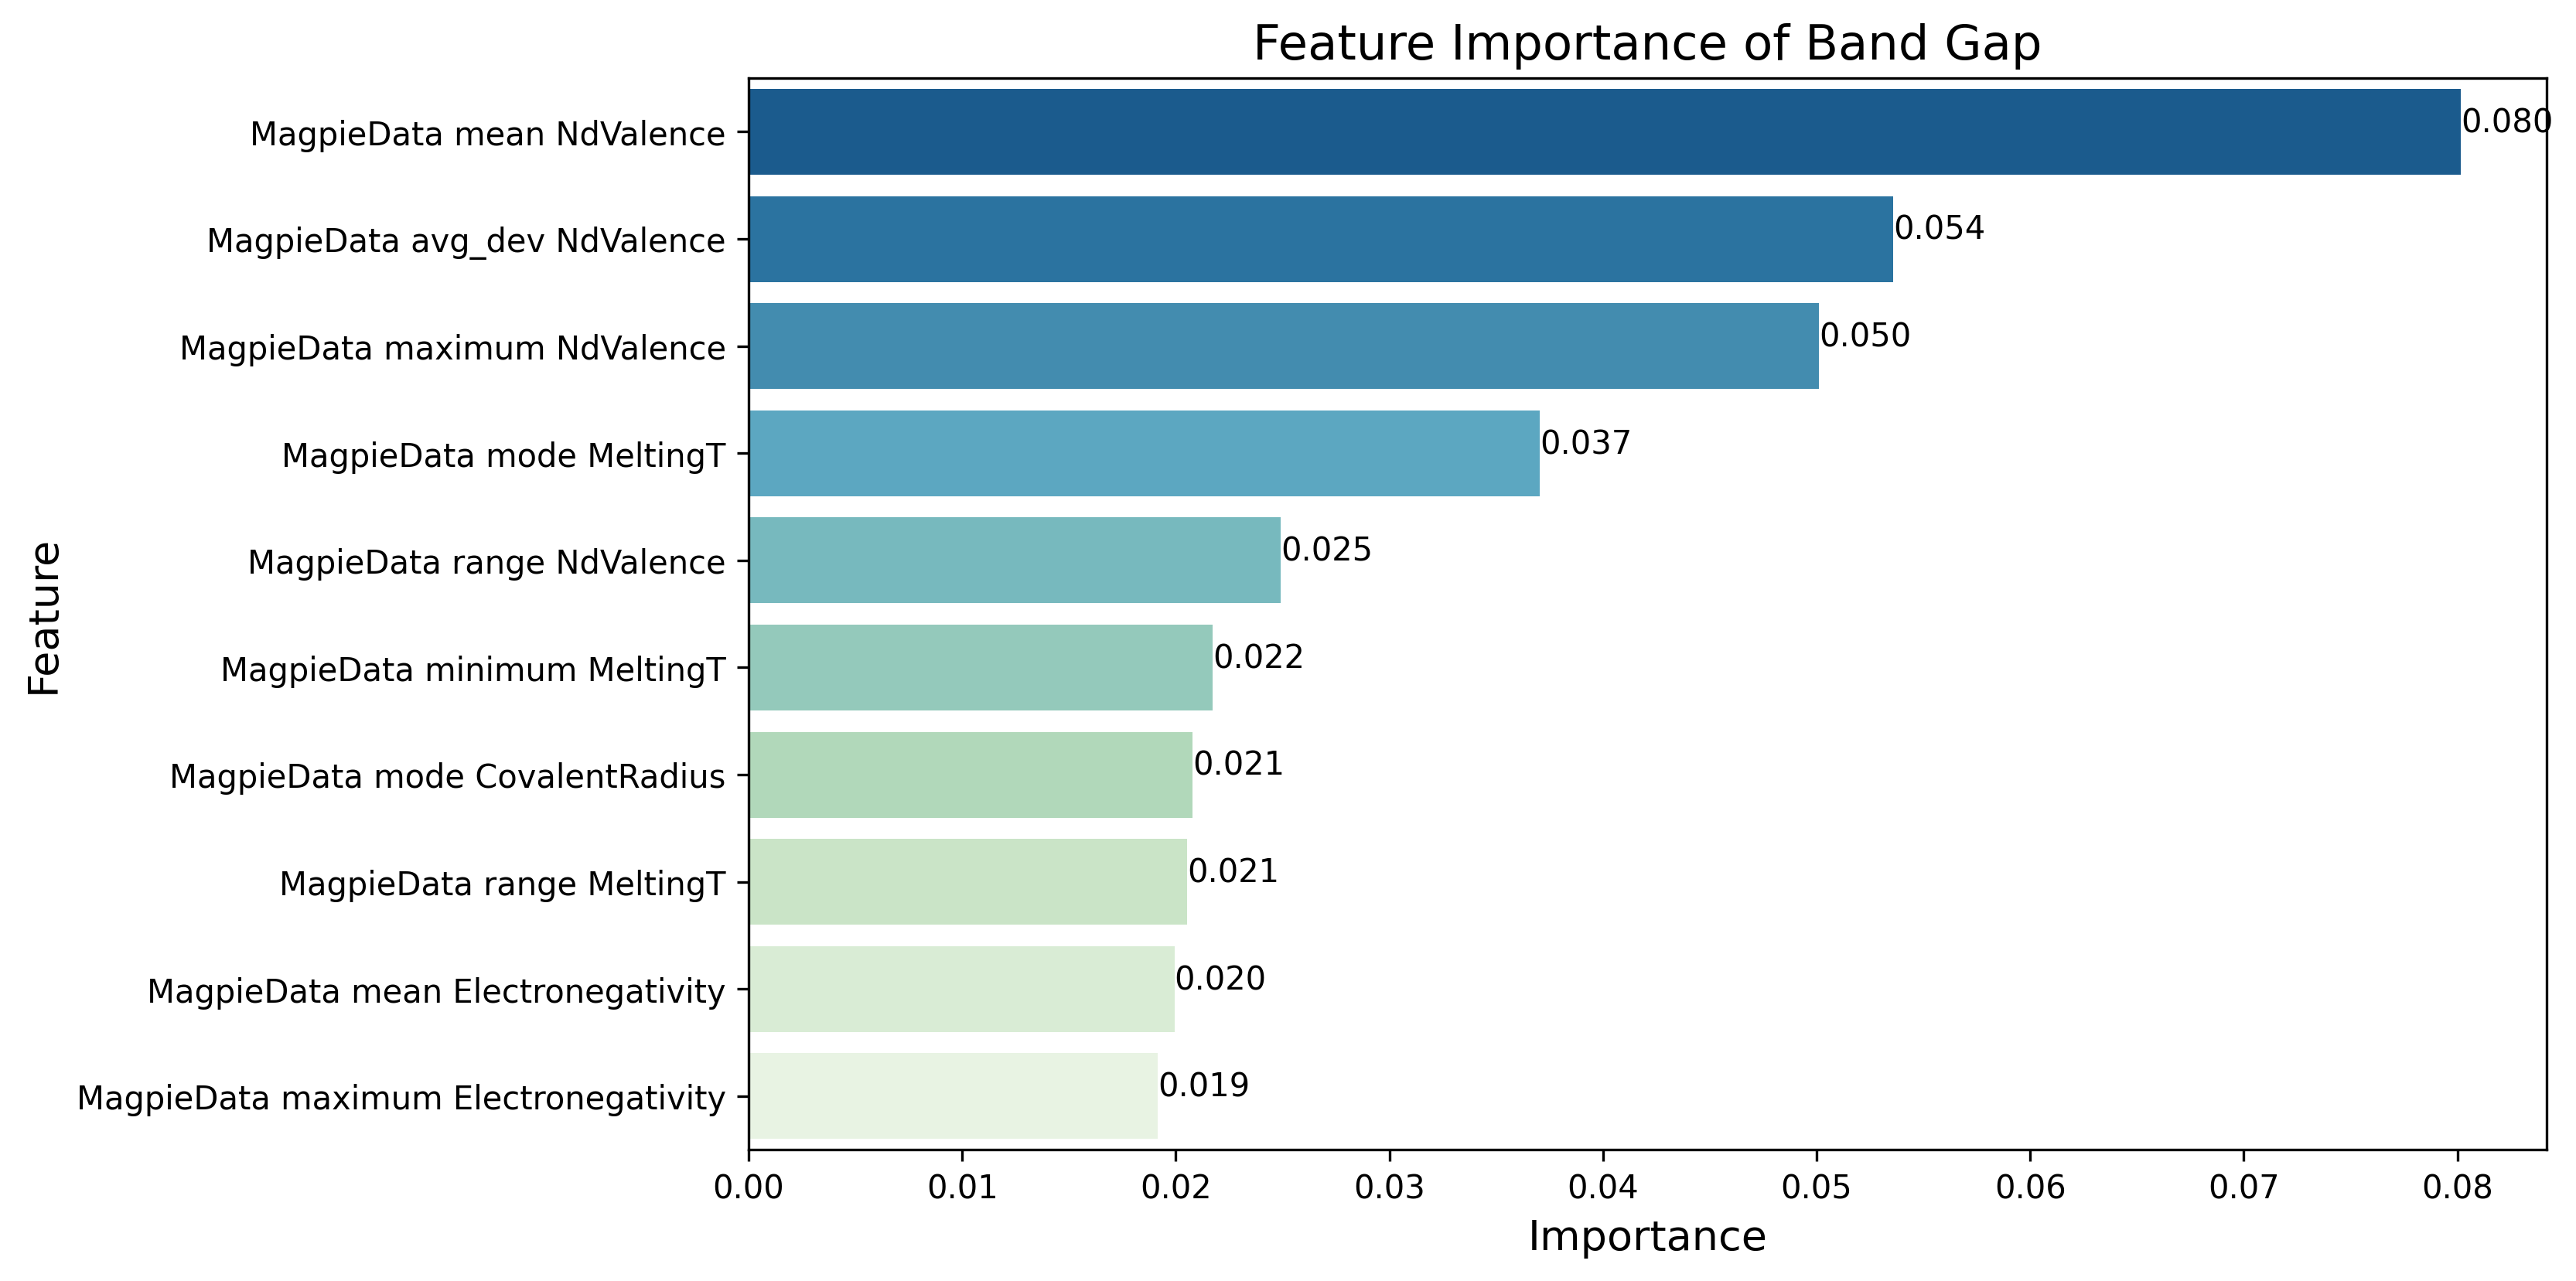

In [15]:
fig_path = os.path.join(current_path, 'figures', 'feature_importance_dft.png')
importances_df = plot_feature_importance(dft_model.named_steps['model'], dft_train_X.columns, top_n=10, fig_path=fig_path)

## Experimental train

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.9s


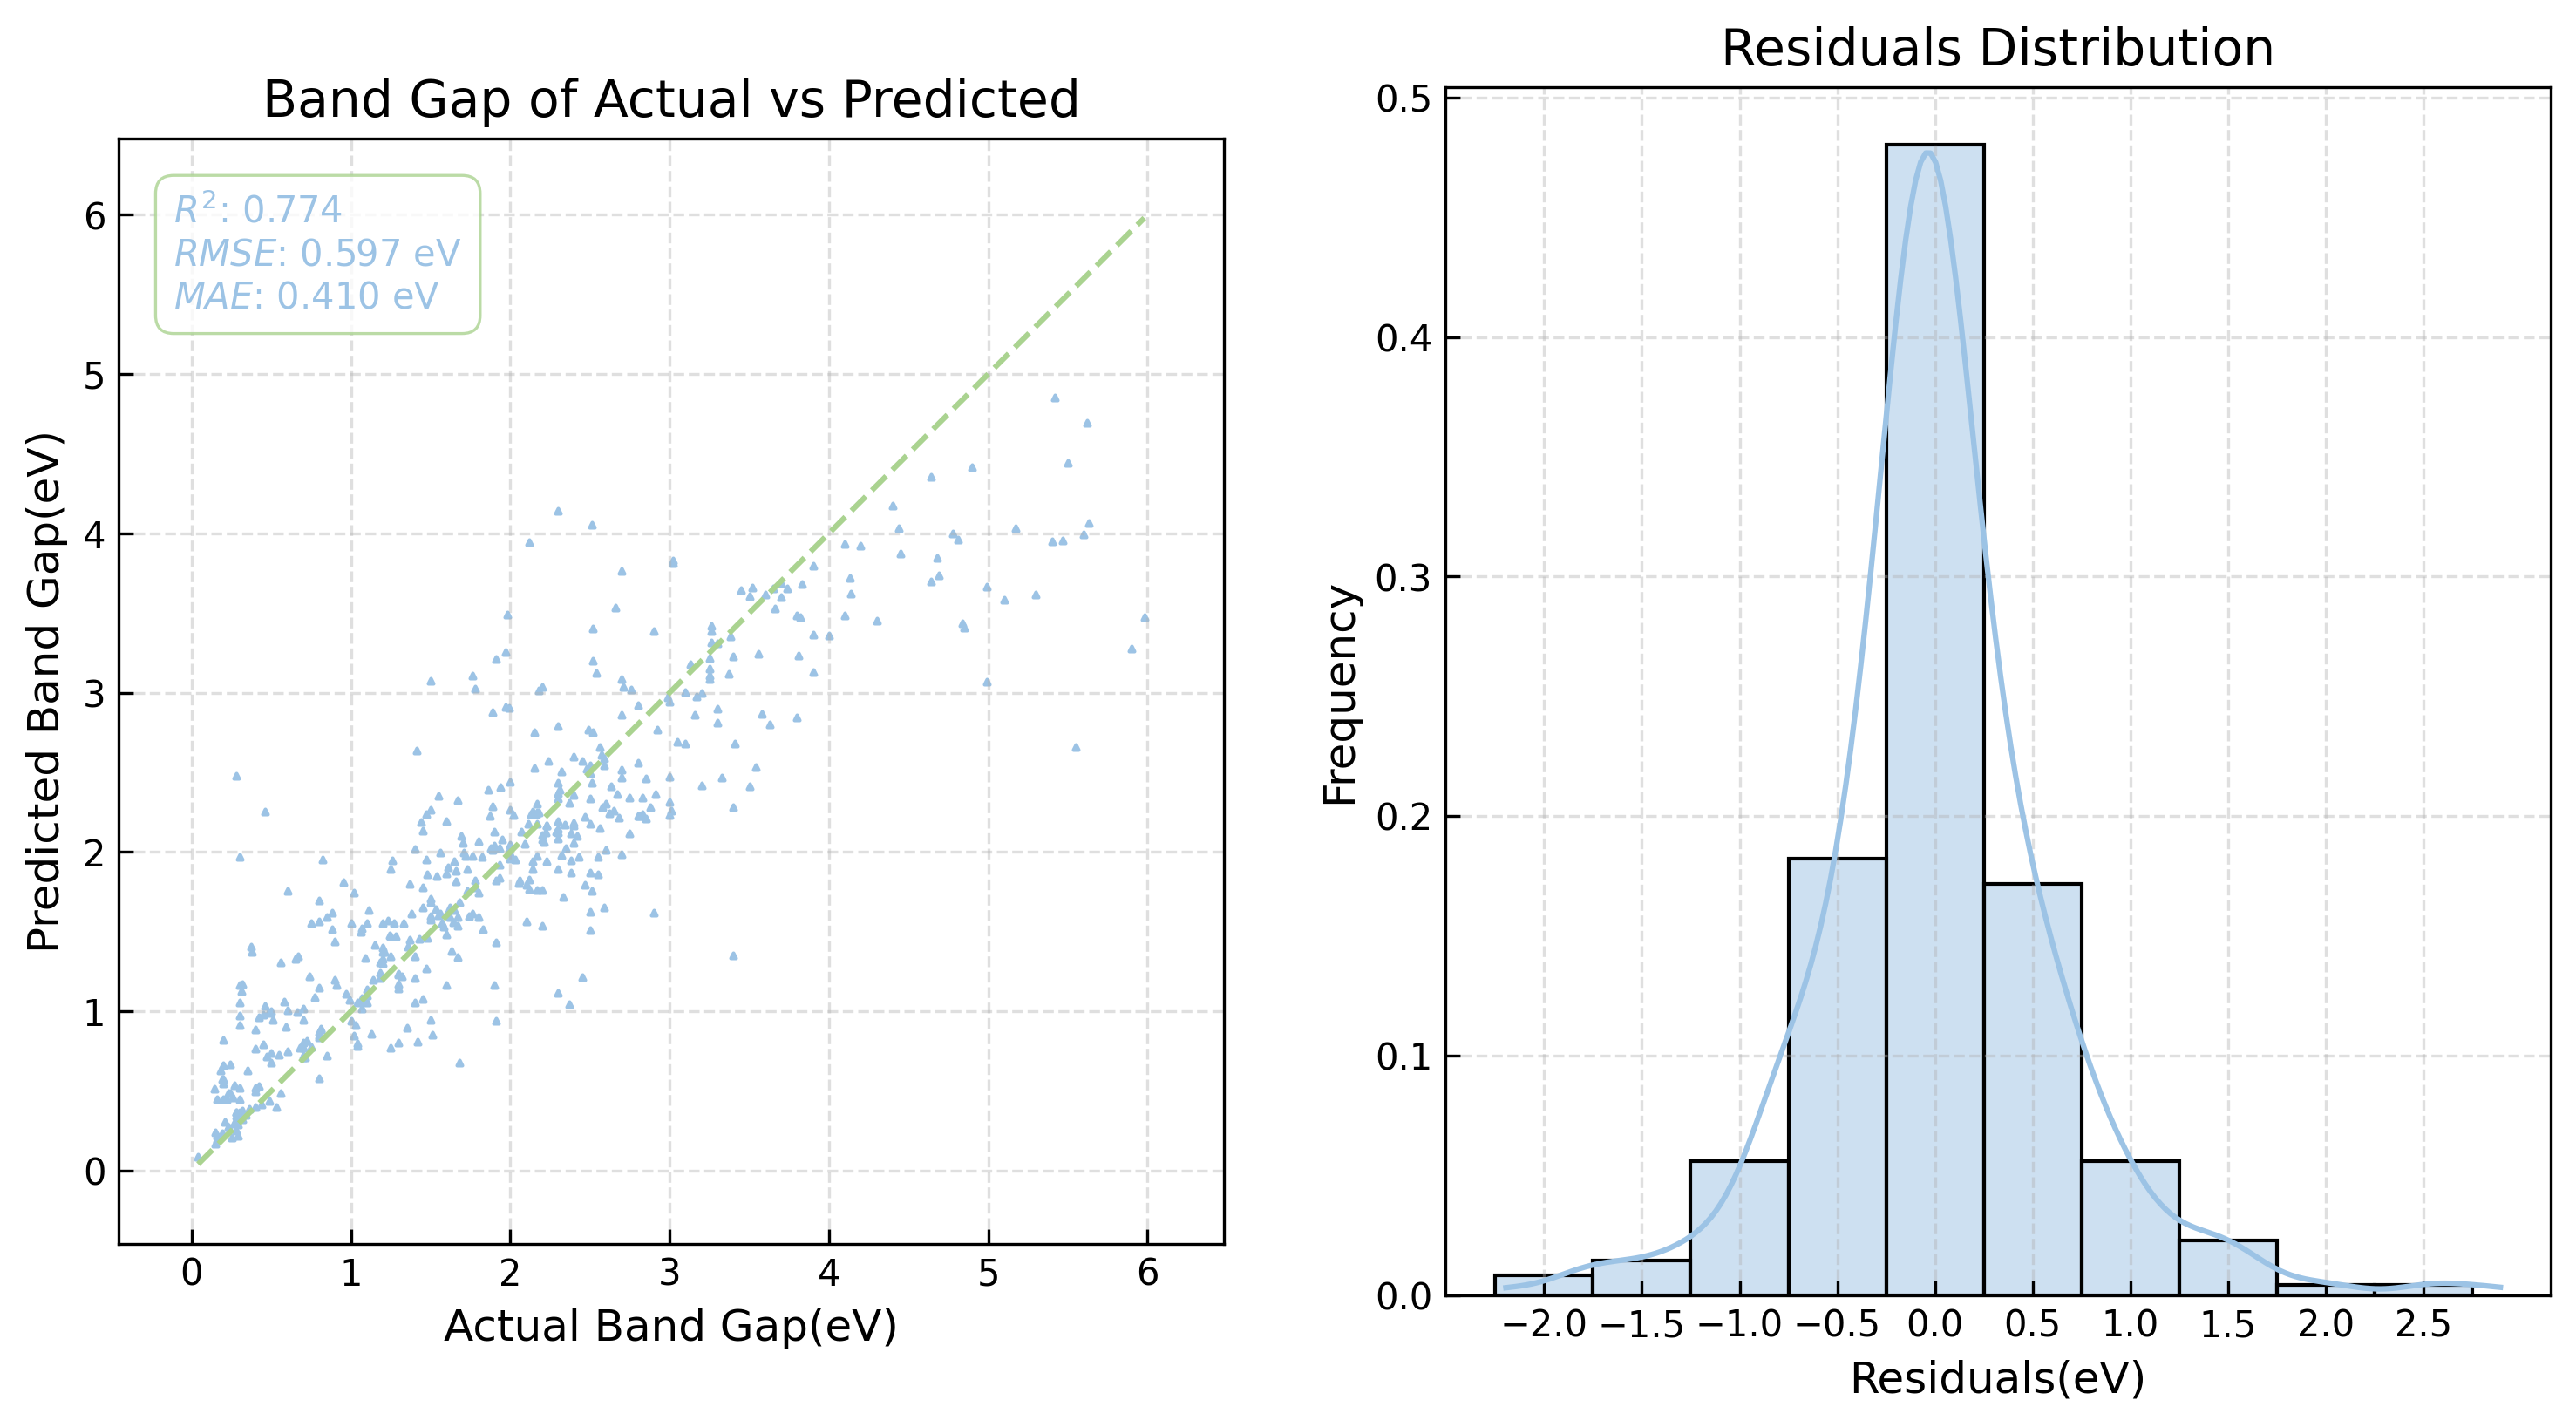

exp_train_exp_test results:
R^2: 0.7740 RMSE: 0.5975 MAE: 0.4096


In [16]:
# Train and evaluate the model on the experimental data
exp_model = model_train(rf_model, exp__train_X, exp__train_y)
# Predict on the test set
res3 = results(exp_model, exp_test_X, exp_test_y, exp_test, train_type='exp', test_type='exp')
results_df.loc[len(results_df)] = ['exp', 'exp'] + res3

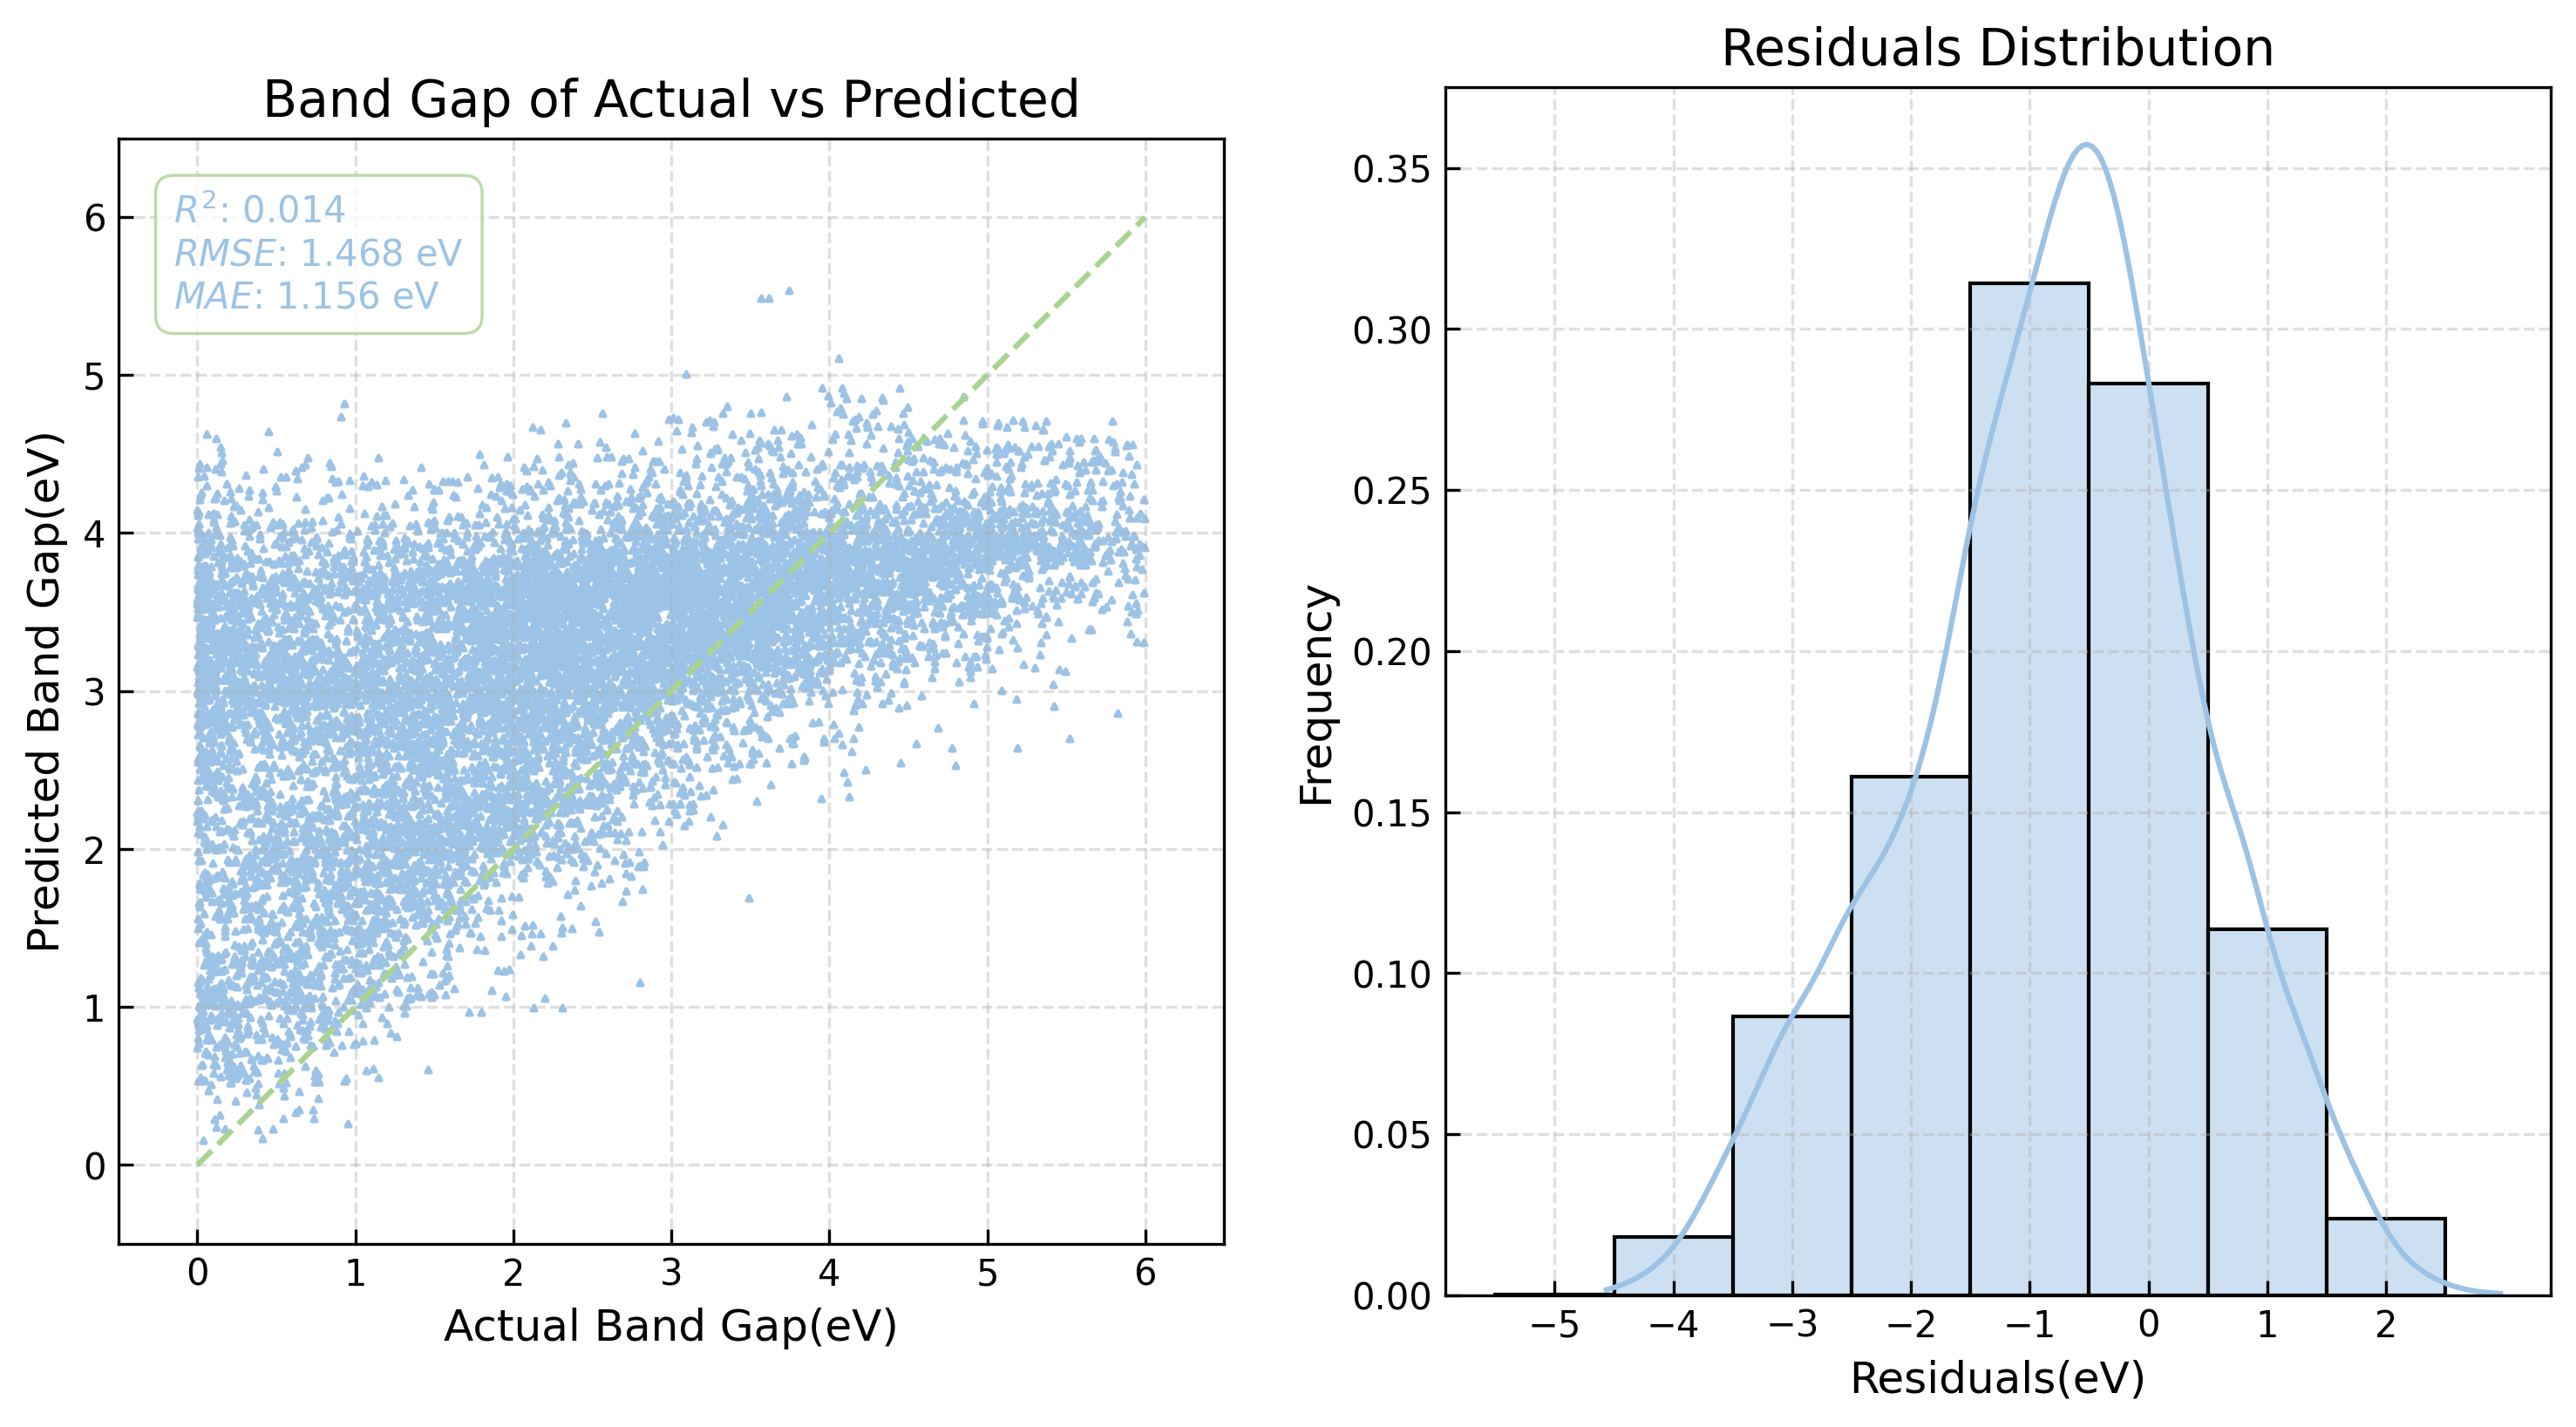

exp_train_dft_test results:
R^2: 0.0137 RMSE: 1.4679 MAE: 1.1558


In [17]:
# Predict on the dft data
res4 = results(exp_model, dft_test_X, dft_test_y, dft_test, train_type='exp', test_type='dft')
results_df.loc[len(results_df)] = ['exp', 'dft'] + res4

### Feature importance

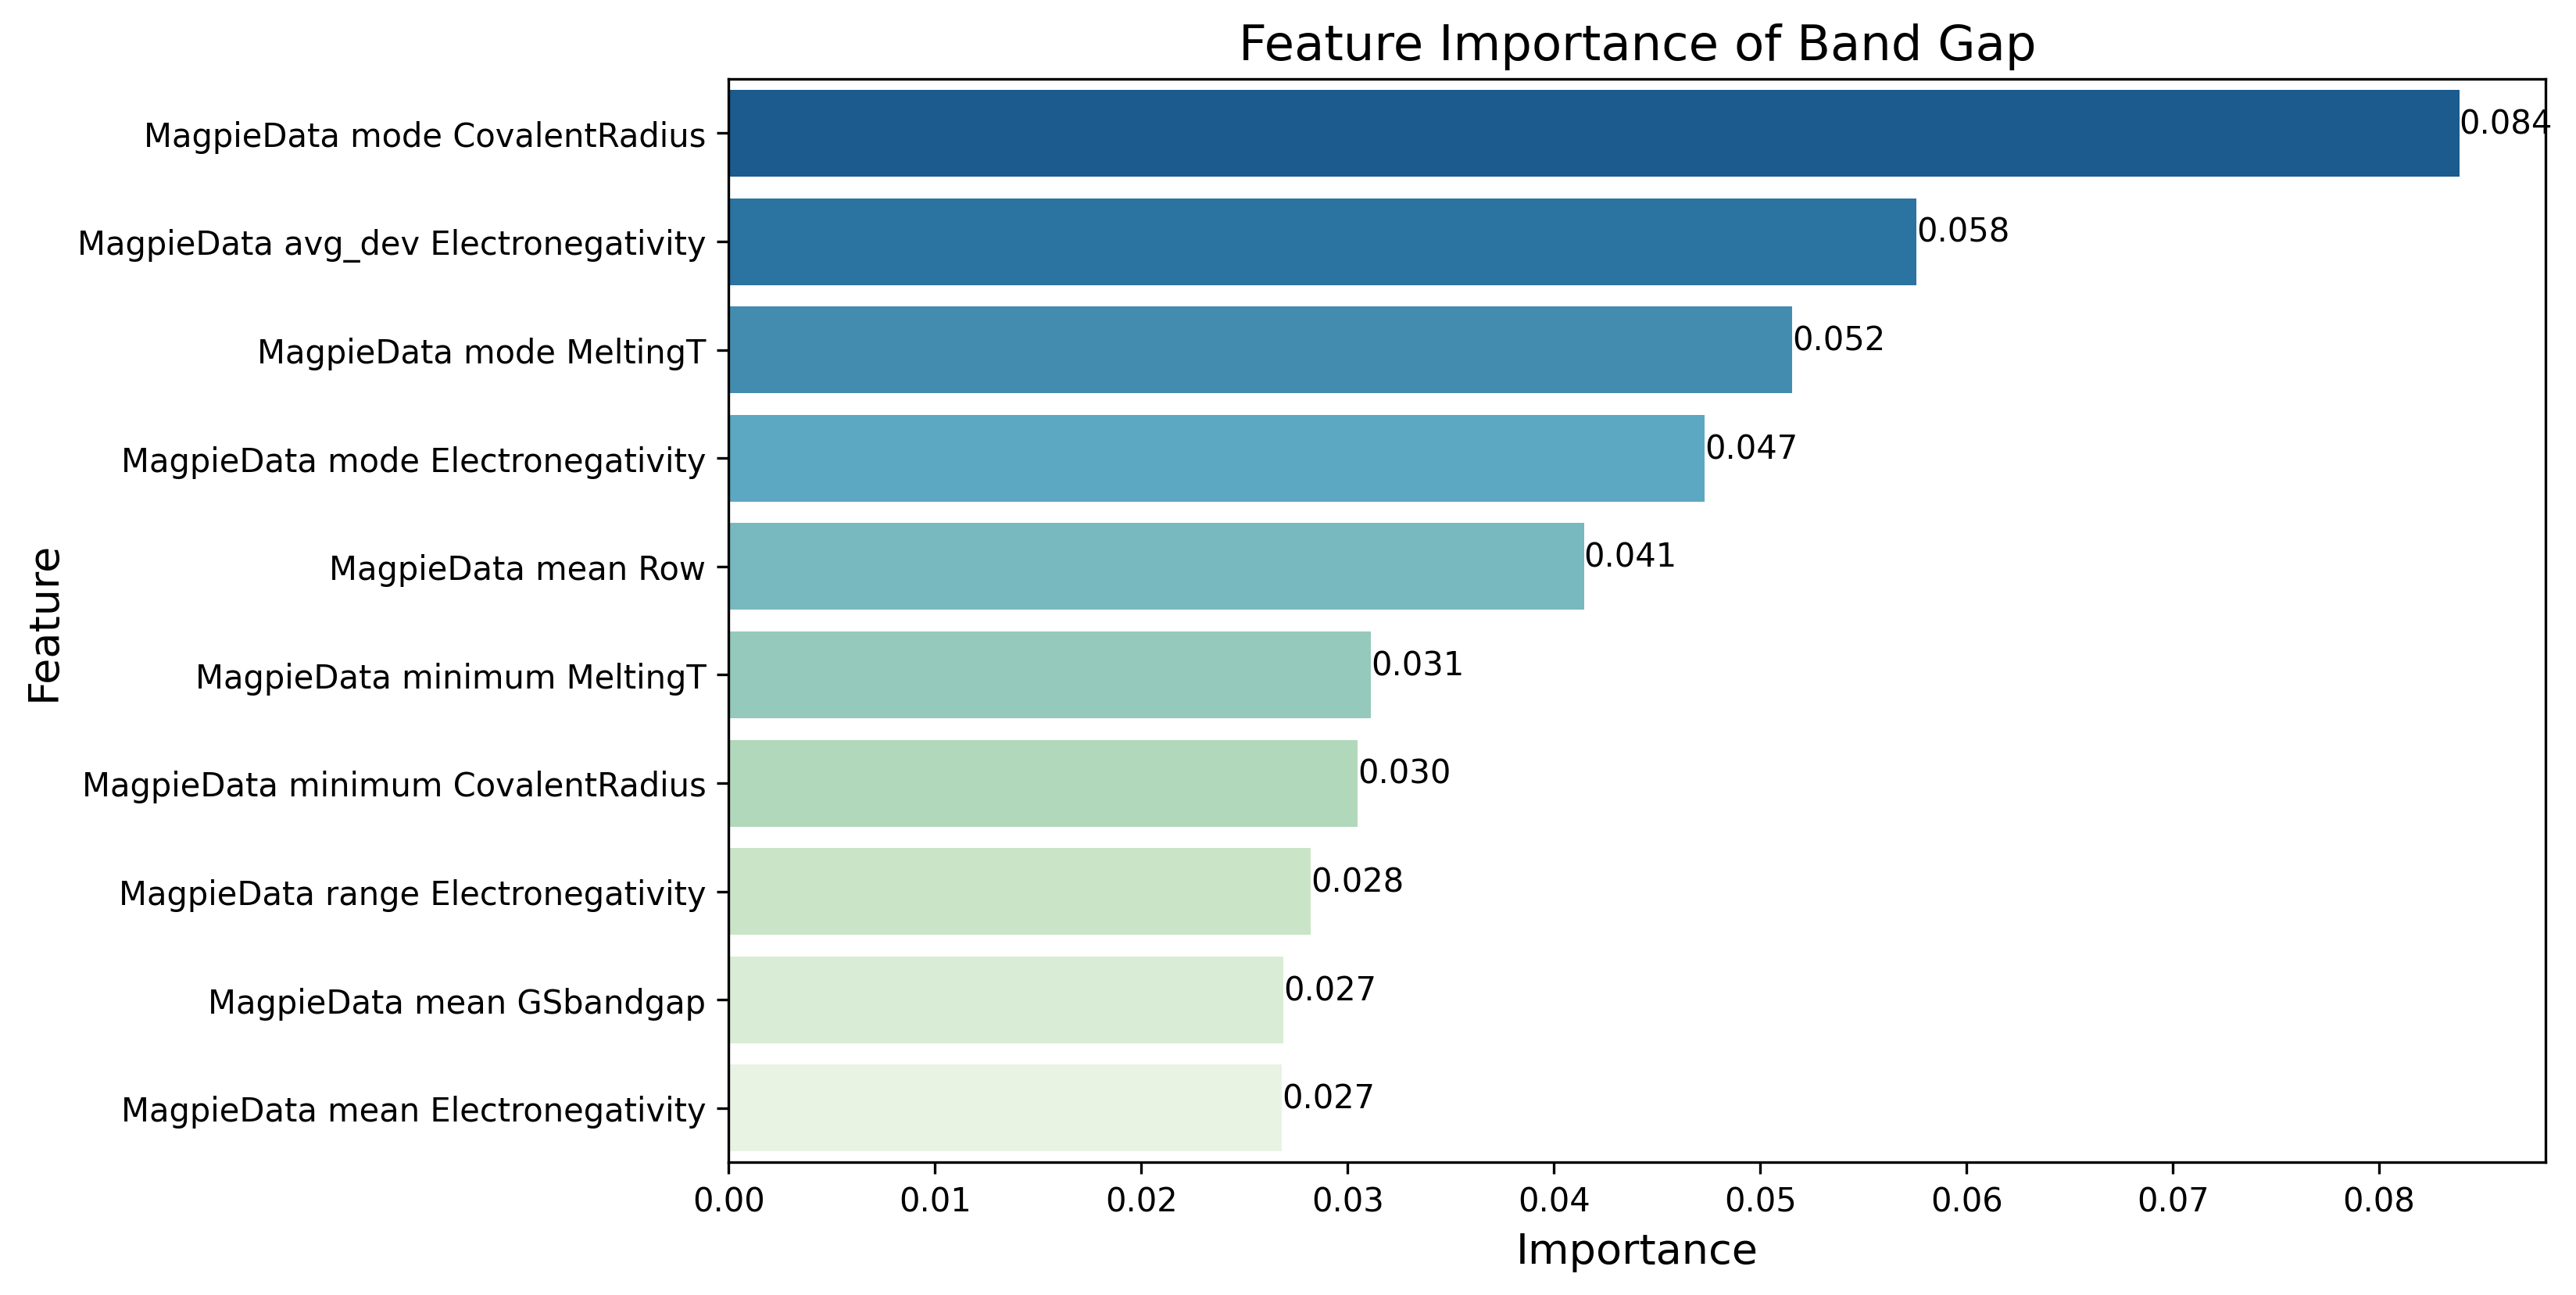

In [18]:
fig_path = os.path.join(current_path, 'figures', 'feature_importance_exp.png')
importances_df = plot_feature_importance(dft_model.named_steps['model'], dft_train_X.columns, top_n=10, fig_path=fig_path)

In [19]:
results_df

,Train,Test,R^2,RMSE,MAE
0,dft,dft,0.774873,0.701336,0.463189
1,dft,exp,0.451031,0.931106,0.745194
2,exp,exp,0.773951,0.597484,0.409644
3,exp,dft,0.013742,1.467939,1.155770


In [20]:
# save the results
file_path = os.path.join(current_path, 'model_performance.csv')
results_df.to_csv(file_path, index=False)